# Problem Statement

This program is designed to classify news articles into distinct categories, including Business, Entertainment, Politics, Sports, and Tech, using a deep learning model. The workflow encompasses multiple stages, such as data preprocessing, text cleaning, tokenization, model construction, and performance evaluation. The goal is to build a robust text classification system that can effectively categorize news articles into the specified topics.


In [ ]:
#!pip install pandas numpy matplotlib seaborn nltk scikit-learn tensorflow wordcloud
#!pip install --upgrade tensorflow
!pip install nltk
!pip install contractions
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.6 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Importing Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

import contractions
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input,Conv1D

# Checking for GPU Availability

In [70]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices available.")
else:
    print(f"Number of GPUs available: {len(physical_devices)}")
    tf.config.set_visible_devices(physical_devices[0], 'GPU')


Number of GPUs available: 1


In [71]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Loading Data

In [72]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Data Exploration

In [73]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [74]:
df.dtypes

category    object
text        object
dtype: object

In [75]:
df.describe()

,category,text
count,2225,2225
unique,5,2125
top,sport,broadband in the uk growing fast high-speed ne...
freq,511,2


In [76]:
df['text'][10]

'berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival.  sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl  21  was arrested and beheaded with her brother  hans  in 1943 for distributing leaflets condemning the  abhorrent tyranny  of adolf hitler. director marc rothemund said:  i have a feeling of responsibility to keep the legacy of the scholls going.   we must somehow keep their ideas alive   he added.  the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund  who worked closely with surviving relatives  including one of scholl s sisters  to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 19

In [77]:
df.isnull().sum()

category    0
text        0
dtype: int64

# Data Visualization

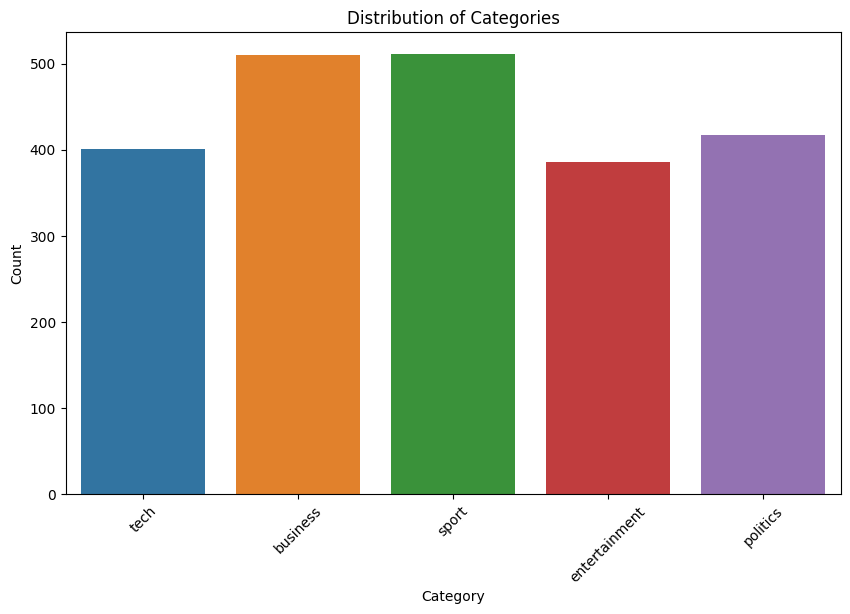

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot of the 'category' column
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')

# Show the plot
plt.show()


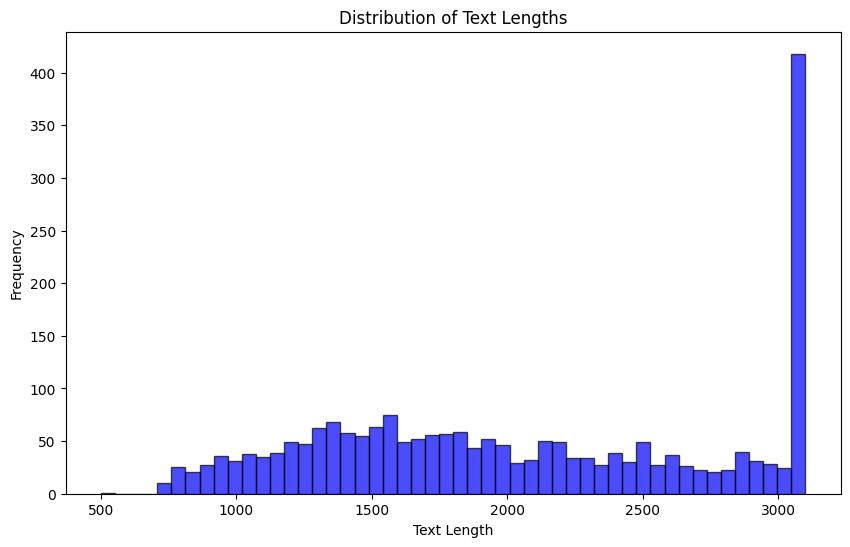

In [79]:
# Calculate the length of each text sample and store it in a new column 'text_length'
df['text_length'] = df['text'].apply(len)

# Create a histogram to visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [80]:
# Calculate the minimum and maximum text lengths
min_length = df['text'].apply(len).min()
max_length = df['text'].apply(len).max()

print(f"Minimum Text Length: {min_length} characters")
print(f"Maximum Text Length: {max_length} characters")


Minimum Text Length: 501 characters
Maximum Text Length: 3100 characters


# Text Cleaning

In [81]:
def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)

In [82]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['text'] = df['text'].apply(lemmatize_text)

In [83]:
def replace_numbers(text):
    return re.sub(r'\d+', '<NUM>', text)

df['text'] = df['text'].apply(replace_numbers)

In [84]:
# Combine all 'text' values into a single string
text_combined = ' '.join(df['text'])

# Tokenize the text into words
words = text_combined.split()

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 50 words by count
top_50_words = word_counts.most_common(50)

# Display the top 50 words and their counts
for word, count in top_50_words:
    print(f'{word}: {count}')


the: 48254
.: 35667
to: 22782
a: 21085
of: 18157
and: 16763
in: 16344
it: 9093
<NUM>: 8931
s: 8384
for: 8124
is: 7503
that: 7242
on: 6935
said: 6926
wa: 5652
he: 5534
be: 5131
with: 4827
ha: 4637
at: 4307
have: 4242
by: 4158
will: 4045
but: 3949
are: 3865
i: 3294
from: 3265
not: 3162
his: 2813
mr: 2786
-: 2776
they: 2708
we: 2663
year: 2638
an: 2543
this: 2487
had: 2438
which: 2392
would: 2340
been: 2313
their: 2161
more: 2052
were: 2043
also: 2004
(: 1990
): 1990
who: 1907
%: 1899
u: 1875


In [85]:
# Regular expressions for cleaning text
text_space_regex = re.compile('[/(){}\[\]\|@,;]')
text_symbols_regex = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
additional_words = {"wa", "ha", "u", "numnum", "numm"}

STOPWORDS = stop_words.union(additional_words)

# Text cleaning function with additional modifications
def clean_and_preprocess_text(input_text):
    # Convert text to lowercase
    cleaned_text = input_text.lower()

    # Replace specified symbols with space
    cleaned_text = text_space_regex.sub(' ', cleaned_text)

    # Remove symbols that are not alphanumeric, space, #, +, or _
    cleaned_text = text_symbols_regex.sub('', cleaned_text)

    # Remove 'x' character
    cleaned_text = cleaned_text.replace('x', '')

    # Tokenize text into words
    words = word_tokenize(cleaned_text)

    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]

    # Join words back into cleaned text
    cleaned_text = ' '.join(words)

    # Remove extra whitespaces and strip leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

df['text']=df['text'].apply(clean_and_preprocess_text)

# Word Cloud Visualization

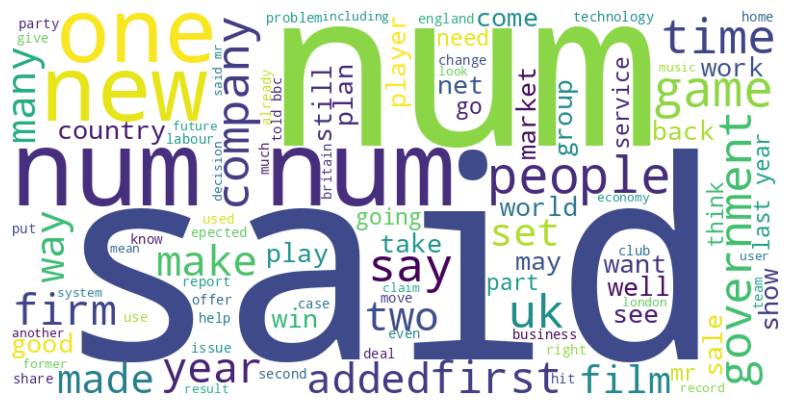

In [86]:
# Combine all 'text' values into a single string
text_combined = ' '.join(df['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenization and Word Frequency

In [87]:
unique_words = set()
for text in df['text']:
    words = word_tokenize(text)
    unique_words.update(words)

total_unique_words = len(unique_words)
total_unique_words

25963

# Tokenization and Data Preparation

In [88]:
from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.8
MAX_NB_WORDS = total_unique_words
MAX_SEQUENCE_LENGTH = max_length
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1780
Test Data size 445


In [89]:
tokenizer = Tokenizer(num_words=total_unique_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 25960


In [90]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1780, 3100)
Testing X Shape: (445, 3100)


In [91]:
labels = list(set(train_data.category.to_list()))

In [92]:
test_data.category

1036    entertainment
372     entertainment
1409         politics
1518         business
279             sport
            ...      
1799         politics
146             sport
544     entertainment
1634             tech
1247    entertainment
Name: category, Length: 445, dtype: object

In [93]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(train_data.category.to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [94]:
# Fit the encoder on the training data labels and transform them
y_train = encoder.fit_transform(train_data.category.to_numpy().reshape(-1, 1))

# Transform the test data labels
y_test = encoder.transform(test_data.category.to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [95]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 15
MODEL_PATH = 'best_model.hdf5'

# Model configuration setup

In [96]:
embeddings_index = {}

# Specify the encoding when opening the file
with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [97]:
(vocab_size, EMBEDDING_DIM)

(25960, 300)

In [98]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [99]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [100]:
epochs = 10,
batch_size = 32,
validation_split = 0.2

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Specify the validation accuracy threshold we want (e.g., 97%)
        target_accuracy = 0.95

        # Check if validation accuracy reaches the target accuracy
        if logs.get('val_accuracy') >= target_accuracy:
            print(f"\nReached target validation accuracy ({target_accuracy * 100:.2f}%). Stopping training.")
            self.model.stop_training = True

custom_callback = CustomCallback()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

# Building and Training the Model

In [101]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(128, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [104]:
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=([custom_callback, reduce_lr]))

Epoch 1/15
 22/112 [====>.........................] - ETA: 47:34 - loss: 0.5212 - accuracy: 0.8551

# Model Evaluation and Visualization

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Making Predictions

In [ ]:
req = ['''how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school kids and that they (and their supporters) need to grow up and stop bickering.  but this analysis in fact gets it wrong. it s not just children who fight - adults do too. and there are solid reasons why even a trivial argument between mature protagonists can be hard to stop once its got going. the key feature of an endless feud is that everyone can agree they d be better off if it ended - but everyone wants to have the last word.  each participant genuinely wants the row to stop  but thinks it worth prolonging the argument just a tiny bit to ensure their view is heard. their successive attempts to end the argument with their last word ensure the argument goes on and on and on. (in the case of mr blair and mr brown  successive books are published  ensuring the issues never die.) now this isn t because the participants are stupid - it s actually each individual behaving entirely rationally  given the incentives facing them. indeed  there s even a piece of economic theory that explains all this. nothing as obscure as  post-neo-classical endogenous growth theory  which the chancellor himself once quoted - but a ubiquitous piece of game theory which all respectable policy wonks are familiar with.  it s often referred to as the  prisoner s dilemma   based on a parable much told in economics degree courses... about a sheriff and two prisoners. the story goes that two prisoners are jointly charged with a heinous crime  and are locked up in separate cells. but the sheriff desperately needs a confession from at least one of them  to provide enough evidence to convict them of the crime. without a confession  the prisoners will get a minimal sentence on some trumped up charge.  clearly the prisoners  best strategy is to keep their mouths shut  and take the short sentence  but the clever sheriff has an idea to induce them to talk. he tells each prisoner separately  that if they confess - and they are the only one to confess - they ll be let off their crime. and he tells them that if they don t confess - and they are the only one not to confess - they ll get life. now  if you are prisoner confronted with this choice  your best bet is to confess. if your partner doesn t confess  you ll get off completely. and if your partner does confess  you d better confess to ensure you don t get life. the result is of course  both prisoners confess  so the sheriff does not have to let either one off. both prisoners  individual logic was to behave that way  even though both would have been better if they had somehow agreed to shut up. don t worry if you don t entirely follow it - you can to look it up on google  where there are 283 000 entries on it.  the prisoners  dilemma and all its ramifications have truly captured economists in the last couple of decades. it is a parable used to describe any situation where there is an obvious sensible choice to be taken collectively  but where the only rational choice individually is to behave selfishly.  a cold war arms r''']
seq = tokenizer.texts_to_sequences(req)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['Business','Entertainment','Politics','Sports','Tech']

max_prob_idx = np.argmax(pred)
predicted_label = labels[max_prob_idx]
confidence_score = float(pred[0][max_prob_idx])

print(predicted_label, format(confidence_score, '.6f'))

Confusion Matrix

Classification Score

In [ ]:
print(classification_report(list(test_data.category), y_pred_1d))

# Saving the Model

In [ ]:
model.save('model.h5')